
<div class="note">
    <p style="margin-top: 0; margin-bottom: 0;">
        <img style="margin-top: 0; margin-bottom: 0; height: 2em;" class="inline-block mr-2 no-fancybox"
            src="https://upload.wikimedia.org/wikipedia/commons/3/38/Jupyter_logo.svg" alt="">
        This page is based on a Jupyter notebook.
<a href="./FbarBenchmarksLocking.ipynb" download="FbarBenchmarksLocking.ipynb"><img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" src="https://img.shields.io/static/v1?label=Download:&message=FbarBenchmarksLocking.ipynb&color=blue" /></a>
<a href="https://gitlab.opengeosys.org/ogs/ogs/-/blob/master/Tests/Data/LargeDeformation/FbarBenchmarksLocking.py"><img src="https://img.shields.io/static/v1?label=Source:&message=FbarBenchmarksLocking.py&color=brightgreen" class="no-fancybox"
        style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;" /></a>
<a href="https://binder.opengeosys.org/v2/gh/bilke/binder-ogs-requirements/6.5.6-0.7.0?urlpath=git-pull%3Frepo=https://gitlab.opengeosys.org/ogs/ogs%26urlpath=lab/tree/ogs/Tests/Data/LargeDeformation/FbarBenchmarksLocking.py%26branch=6.5.6%26depth=1">
    <img class="no-fancybox" style="display: inline; margin-top: 0; margin-bottom: 0; margin-left: 1em;"
        src="https://img.shields.io/static/v1?label=&message=Launch notebook&color=5c5c5c&logo=" />
</a></p></div>

$$
\newcommand{\J}{\text{J}}
\newcommand{\F}{\text{F}}
$$

# F-bar method applied to large deformation problems exhibiting volumetric locking

These benchmarks are taken from [1] but employ a basic Neo-Hookean hyperelastic model as described below.
The Neo-Hookean model defines an energy function as the sum of volumetric component $U_{\text{dil}}(\F)$ and deviatoric component $U_{\text{dev}}(\F)$ as
$$
\begin{align}
W(\F) = U_{\text{dil}}(\F) + U_{\text{dev}}(\F),
\end{align}
$$
where
$$
\begin{align}
& U_{\text{dil}}(\F) = \dfrac{1}{2} K (\det(\F)-1)^2\\
& U_{\text{dev}}(\F) = \dfrac{1}{2} G \left(\text{tr} (\det(\F)^{-\frac{2}{3}}\F\F^{\text{T}})-3\right)
\end{align}
$$
with $K$ the bulk modulus, and $G$ the shear modulus.

For each following examples a contour plot of the displacement field in the deformed mesh is shown after the simulation finishes.

In [1]:
import os
from pathlib import Path

import numpy as np
import ogstools as ot
import pyvista as pv

pv.set_jupyter_backend("static" if "CI" in os.environ else "client")

out_dir = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
out_dir.mkdir(parents=True, exist_ok=True)

In [2]:
class SingleOGSModel:
    """An OGS run model"""

    def __init__(self, project_name: str, use_fbar: bool):
        self.prj = ot.Project(
            input_file=Path(project_name) / f"{project_name}.prj",
            output_file=out_dir / "modified.prj",
        )
        self.prj.replace_text(project_name, "./time_loop/output/prefix")
        if not use_fbar:
            self.prj.replace_text("none", "./processes/process/f_bar")
        self.project_name = project_name
        self.use_fbar = use_fbar

    def reset_time_step_size(self, dt: float, n_steps: int):
        xpath = "./time_loop/processes/process[1]/time_stepping/timesteps/pair[1]/"
        self.prj.replace_text(str(dt), xpath + "delta_t")
        self.prj.replace_text(n_steps, xpath + "repeat")

    def run(self) -> ot.MeshSeries:
        self.prj.write_input()
        self.prj.run_model(
            logfile=out_dir / "out.txt", args=f"-o {out_dir} -m {self.project_name}"
        )
        return ot.MeshSeries(out_dir / (self.project_name + ".pvd"))

    def run_benchmark(self, u_max_ref: list[float]):
        results = self.run()
        u_max_pt = np.argmax(ot.variables.displacement.magnitude.transform(results[-1]))
        u_max_num = results[-1]["displacement"][u_max_pt]
        np.testing.assert_allclose(u_max_num, u_max_ref, rtol=1e-4)
        f_bar_info = "With F-bar" if self.use_fbar else "Without F-bar"
        print(
            f"{f_bar_info}, the obtained maximum displacement"
            f" of {self.project_name} is {u_max_num} m."
        )
        self.plot3D(results[-1])

    def plot3D(self, mesh: pv.UnstructuredGrid):
        dim = np.max([cell.dimension for cell in mesh.cell])
        if dim == 2:
            zeros = np.zeros((mesh.n_points, 1))
            mesh["displacement"] = np.hstack((mesh["displacement"], zeros))
        deformed_mesh = mesh.warp_by_vector("displacement")
        pl = pv.Plotter()
        pl.camera_position = "xy" if dim == 2 else (-0.5, -0.5, 0.4)
        pl.add_mesh(mesh, color="lightgrey", style="wireframe", line_width=1)
        pl.add_mesh(deformed_mesh, scalars="displacement", show_edges=True, cmap="jet")
        pl.show_axes()
        pl.reset_camera()
        pl.show()

## A block under compression

This is a plane strain problem.
The domain size is 0.01 m $\times$ 0.01 m.
The geometry and boundary conditions are shown in the following figure:

<img src="./figures/ld_rubber_indentation.png" alt="Simple test" width="200" height="200" />

The values of Young's modulus ($E$) and Poisson's ratio ($\nu$) are calculated from the specified bulk modulus of 400,889.806 MPa and the shear modulus of 80.194 MPa.
The calculated Poisson's ratio is close to 0.5, indicating that the material is nearly incompressible.

### Simulation without the F-bar method

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/FbarBenchmarksLocking/modified.prj
Status: finished successfully.
Execution took 0.20155858993530273 s
Without F-bar, the obtained maximum displacement of RubberIndentation is [ 0.         -0.00010429] m.


2025-10-30 14:42:32.814 (   0.983s) [    7FAC78834400]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


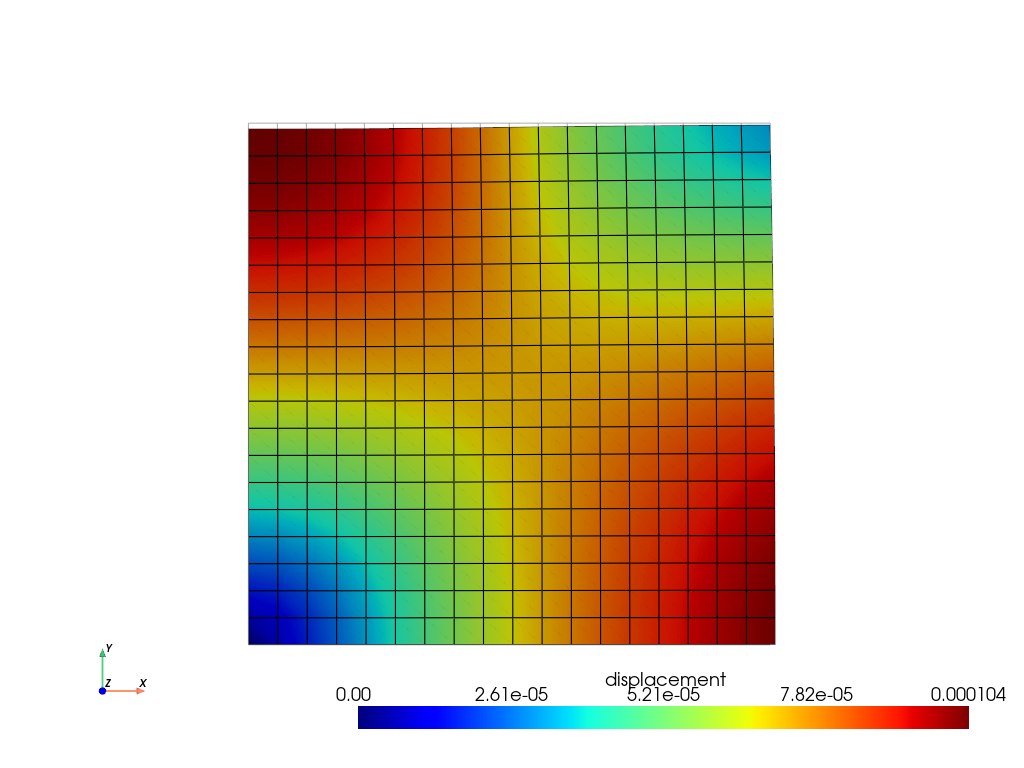

In [3]:
ogs_model = SingleOGSModel("RubberIndentation", use_fbar=False)
ogs_model.run_benchmark(u_max_ref=[0, -0.00010428732840299523])

### Simulation with the F-bar method

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/FbarBenchmarksLocking/modified.prj
Status: finished successfully.
Execution took 0.35679030418395996 s
With F-bar, the obtained maximum displacement of RubberIndentation is [ 0.         -0.00026708] m.


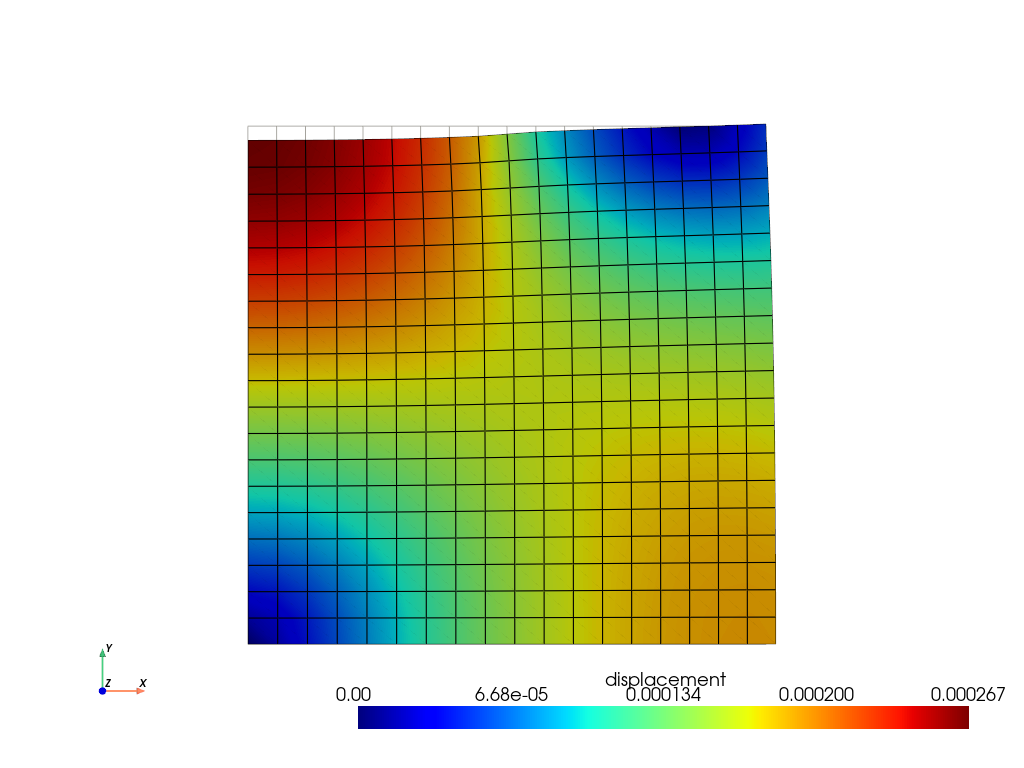

In [4]:
ogs_model = SingleOGSModel("RubberIndentation", use_fbar=True)
ogs_model.run_benchmark(u_max_ref=[0, -0.00026707547768988984])

## 3D indentation example

<img align="left" src="./figures/ld_block_compression.png" alt="Simple test" width="200" height="200" />
This example analyzes the deformation of a block ($0.01\times 0.01 \times 0.01\,\text{m}^3$) under indentation.
As shown in the figure, a uniformly distributed pressure of 40 MPa is applied to one-quarter of the top surface.
On the symmetry surfaces, the displacement in the normal direction is fixed, while on the bottom surface, the vertical displacement is fixed.
The material parameters are the same as those used in the previous example.

### Simulation without the F-bar method

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/FbarBenchmarksLocking/modified.prj
Status: finished successfully.
Execution took 1.555370569229126 s
Without F-bar, the obtained maximum displacement of Indentation3D is [ 0.00000000e+00  0.00000000e+00 -1.65344843e-05] m.


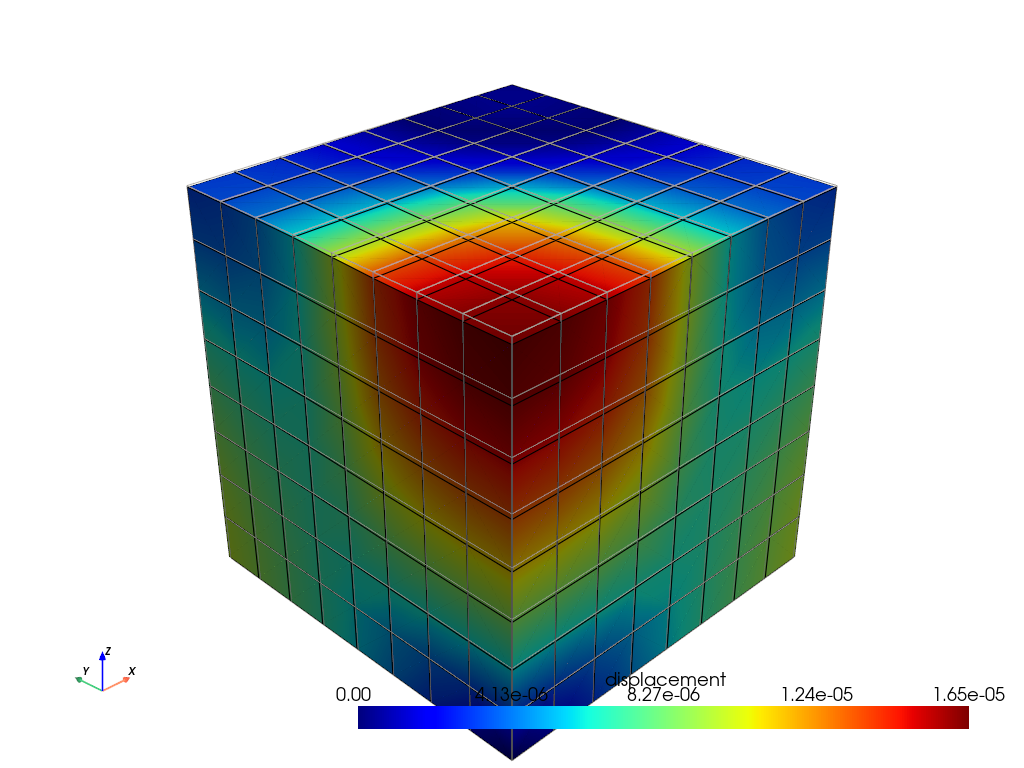

In [5]:
ogs_model = SingleOGSModel("Indentation3D", use_fbar=False)
ogs_model.run_benchmark(u_max_ref=[0, 0, -1.6534484343296282e-05])

### Simulation with the F-bar method

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/FbarBenchmarksLocking/modified.prj
Status: finished successfully.
Execution took 14.145857810974121 s
With F-bar, the obtained maximum displacement of Indentation3D is [ 0.          0.         -0.00010954] m.


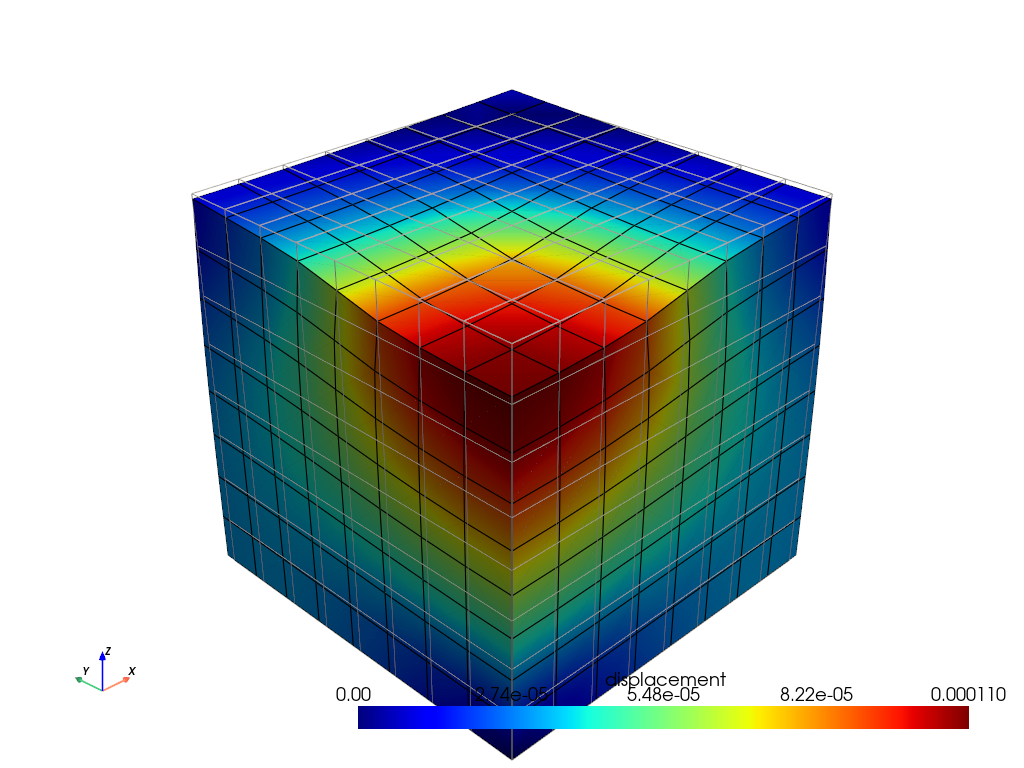

In [6]:
ogs_model = SingleOGSModel("Indentation3D", use_fbar=True)
ogs_model.run_benchmark(u_max_ref=[0, 0, -0.00010953948059235105])

## Thick cylindrical shell under pressure

<img align="left" src="./figures/ld_cylindrical_shell.png" alt="Simple test" width="100" height="100" />

This example analyzes the deformation of a cylindrical shell (R=$0.01\,\text{m}$, thickness=$0.002\,\text{m}$, H=$0.015\,\text{m}$) under radial pressure.
Due to symmetry, only half of the shell is considered.
The normal displacement on the symmetry surfaces is fixed.
The other boundary conditions are shown in the figure, where the uniformly distributed pressure is 6 MPa/m.
The bulk modulus is 240 GPa, and the shear modulus is 6 GPa, corresponding to a Poisson's ratio of 0.4.

### Simulation without the F-bar method

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/FbarBenchmarksLocking/modified.prj
Status: finished successfully.
Execution took 12.575017929077148 s
Without F-bar, the obtained maximum displacement of ThickCylindricalShell is [ 0.         -0.01192143  0.00029815] m.


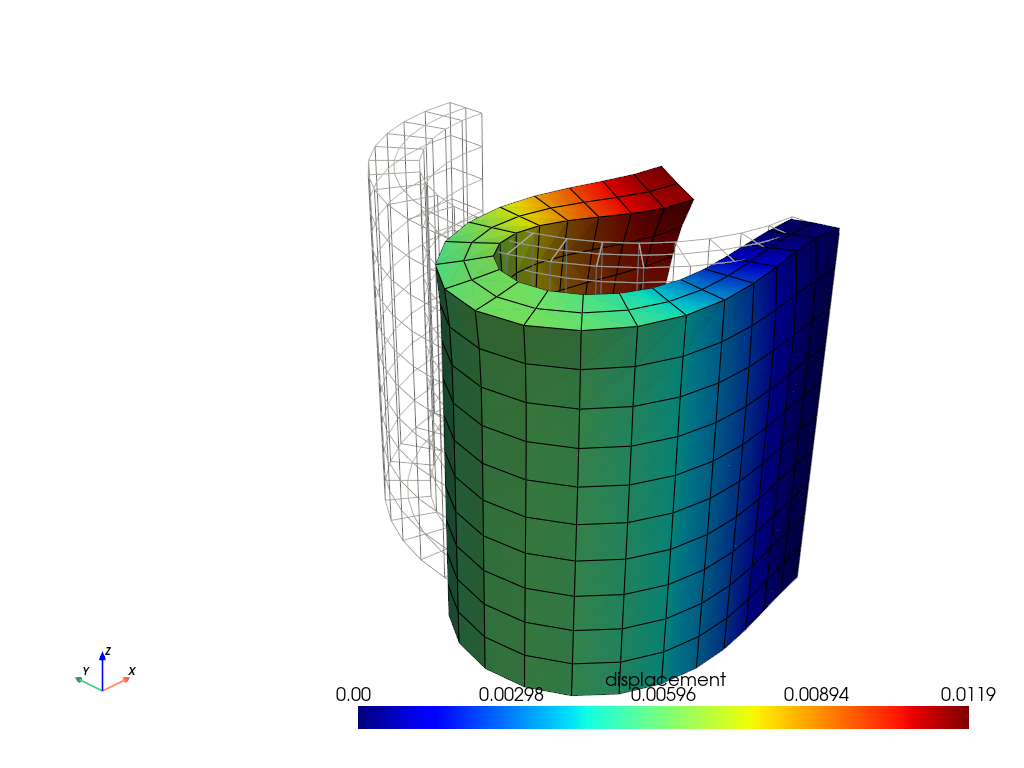

In [7]:
ogs_model = SingleOGSModel("ThickCylindricalShell", use_fbar=False)
ogs_model.reset_time_step_size(0.3, 4)
ogs_model.run_benchmark(u_max_ref=[0, -0.01192143, 0.00029815])

### Simulation with the F-bar method

Project file written to output.
Simulation: /var/lib/gitlab-runner/builds/vZ6vnZiU/0/ogs/build/release-all/Tests/Data/LargeDeformation/FbarBenchmarksLocking/modified.prj
Status: finished successfully.
Execution took 7.267627477645874 s
With F-bar, the obtained maximum displacement of ThickCylindricalShell is [ 0.         -0.01510393  0.00022727] m.


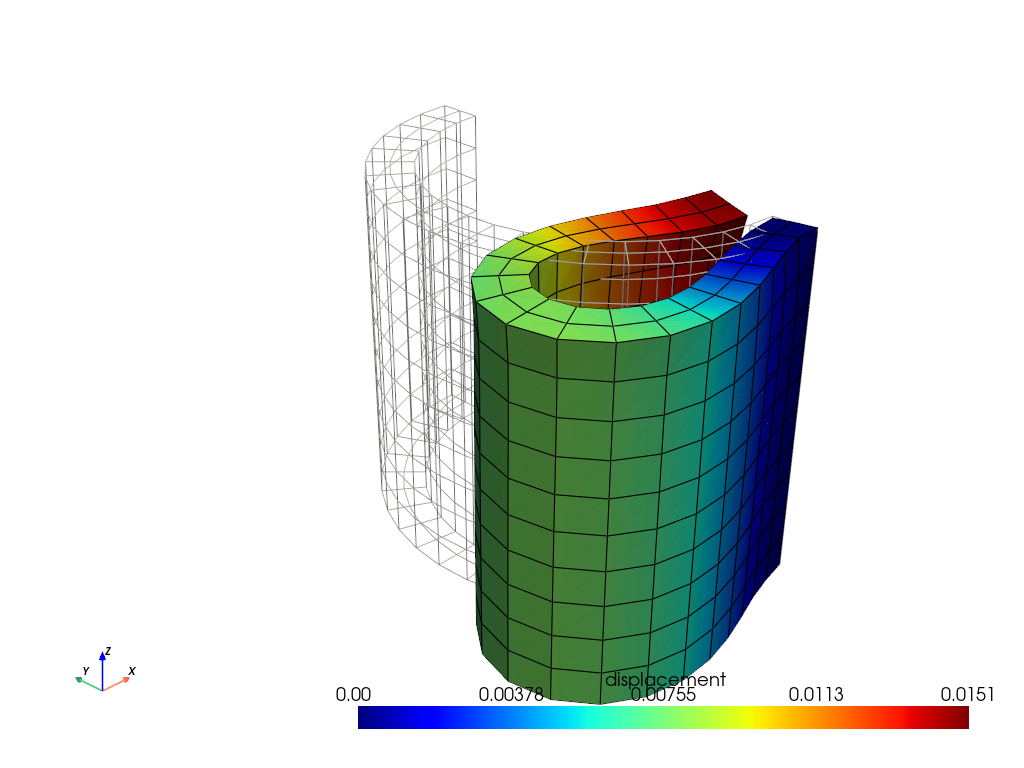

In [8]:
ogs_model = SingleOGSModel("ThickCylindricalShell", use_fbar=True)
ogs_model.run_benchmark(u_max_ref=[0, -0.01510393, 0.00022727])

## Reference

1. T. Elguedj, Y. Bazilevs, V.M. Calo, T.J.R. Hughes (2008),
$\bar\B$ and $\bar{\text F}$ projection methods for nearly incompressible linear and non-linear elasticity and plasticity using higher-order NURBS elements, Computer Methods in Applied Mechanics and Engineering, 197(33–40), 2732-2762.
